# Importing all required things

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
!pip install -q imbalanced-learn xgboost lightgbm shap catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 10.1 MB/s eta 0:00:00


In [2]:
# Force Upgrade XGboost
!pip install -U xgboost --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 253.9/253.9 MB 6.1 MB/s eta 0:00:00


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

In [4]:
from sklearn.linear_model import LogisticRegression,SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier,ExtraTreesClassifier
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score,classification_report,confusion_matrix,roc_auc_score,precision_recall_curve,roc_curve,average_precision_score

# Data preprocessing

In [ ]:
pd.set_option('display.max_columns',None)

In [ ]:
df=pd.read_csv("/content/drive/MyDrive/data.csv")

In [ ]:
# converting from float64 to float32 and int64 to int8 to reduce memory usage
for col in df.select_dtypes(include="float64").columns:
    df[col]=df[col].astype("float32")
for col in df.select_dtypes(include="int64").columns:
    df[col]=df[col].astype("int8")

In [ ]:
#checking for null values in any column
df.isnull().sum()

,0
Bankrupt?,0
ROA(C) before interest and depreciation before interest,0
ROA(A) before interest and % after tax,0
ROA(B) before interest and depreciation after tax,0
Operating Gross Margin,0
...,...
Liability to Equity,0
Degree of Financial Leverage (DFL),0
Interest Coverage Ratio (Interest expense to EBIT),0
Net Income Flag,0


In [ ]:
# checking for duplicated rows
df.duplicated().sum()

np.int64(0)

In [ ]:
# if any column contain only single value
df.columns[df.nunique()==1]

Index([' Net Income Flag'], dtype='object')

In [ ]:
# deleting single-valued column
del df[" Net Income Flag"]

In [ ]:
# minimun and maximum values of every column
df.describe().T[['min','max']]

,min,max
Bankrupt?,0.0,1.0
ROA(C) before interest and depreciation before interest,0.0,1.0
ROA(A) before interest and % after tax,0.0,1.0
ROA(B) before interest and depreciation after tax,0.0,1.0
Operating Gross Margin,0.0,1.0
...,...,...
Net Income to Stockholder's Equity,0.0,1.0
Liability to Equity,0.0,1.0
Degree of Financial Leverage (DFL),0.0,1.0
Interest Coverage Ratio (Interest expense to EBIT),0.0,1.0


In [ ]:
# separating output labels from features
y=df["Bankrupt?"]
df=df.drop("Bankrupt?",axis=1)

## Identifying and Handling Outliers

### IQR method

In [ ]:
# Compute IQR(InterQuantile Range)
Q1=df.quantile(0.25) # 25% data is below this value
Q3=df.quantile(0.75) # 75% data is below this value
IQR=Q3-Q1            # spread of middle 50% of data

Lower_bound= Q1 - 1.5*IQR
Upper_bound= Q3 + 1.5*IQR
# Boolean mask of outliers
is_outlier=((df<Lower_bound) | (df>Upper_bound)).any(axis=1)

In [ ]:
is_outlier.sum()
# since iqr method identifies most of rows as outlier this is not good method here

np.int64(6361)

### taking log of cols which contain very extreme values

In [ ]:
cols_to_log=[col for col in df.columns if df[col].max() >1e6]

In [ ]:
# taking log(1+x) so that very small values does not get converted to -infinity
df[cols_to_log]=df[cols_to_log].apply(lambda x: np.log1p(x))

In [ ]:
df.head(5)

,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,Operating Gross Margin,Realized Sales Gross Margin,Operating Profit Rate,Pre-tax net Interest Rate,After-tax net Interest Rate,Non-industry income and expenditure/revenue,Continuous interest rate (after tax),Operating Expense Rate,Research and development expense rate,Cash flow rate,Interest-bearing debt interest rate,Tax rate (A),Net Value Per Share (B),Net Value Per Share (A),Net Value Per Share (C),Persistent EPS in the Last Four Seasons,Cash Flow Per Share,Revenue Per Share (Yuan ¥),Operating Profit Per Share (Yuan ¥),Per Share Net profit before tax (Yuan ¥),Realized Sales Gross Profit Growth Rate,Operating Profit Growth Rate,After-tax Net Profit Growth Rate,Regular Net Profit Growth Rate,Continuous Net Profit Growth Rate,Total Asset Growth Rate,Net Value Growth Rate,Total Asset Return Growth Rate Ratio,Cash Reinvestment %,Current Ratio,Quick Ratio,Interest Expense Ratio,Total debt/Total net worth,Debt ratio %,Net worth/Assets,Long-term fund suitability ratio (A),Borrowing dependency,Contingent liabilities/Net worth,Operating profit/Paid-in capital,Net profit before tax/Paid-in capital,Inventory and accounts receivable/Net value,Total Asset Turnover,Accounts Receivable Turnover,Average Collection Days,Inventory Turnover Rate (times),Fixed Assets Turnover Frequency,Net Worth Turnover Rate (times),Revenue per person,Operating profit per person,Allocation rate per person,Working Capital to Total Assets,Quick Assets/Total Assets,Current Assets/Total Assets,Cash/Total Assets,Quick Assets/Current Liability,Cash/Current Liability,Current Liability to Assets,Operating Funds to Liability,Inventory/Working Capital,Inventory/Current Liability,Current Liabilities/Liability,Working Capital/Equity,Current Liabilities/Equity,Long-term Liability to Current Assets,Retained Earnings to Total Assets,Total income/Total expense,Total expense/Assets,Current Asset Turnover Rate,Quick Asset Turnover Rate,Working capitcal Turnover Rate,Cash Turnover Rate,Cash Flow to Sales,Fixed Assets to Assets,Current Liability to Liability,Current Liability to Equity,Equity to Long-term Liability,Cash Flow to Total Assets,Cash Flow to Liability,CFO to Assets,Cash Flow to Equity,Current Liability to Current Assets,Liability-Assets Flag,Net Income to Total Assets,Total assets to GNP price,No-credit Interval,Gross Profit to Sales,Net Income to Stockholder's Equity,Liability to Equity,Degree of Financial Leverage (DFL),Interest Coverage Ratio (Interest expense to EBIT),Equity to Liability
0,0.370594,0.424389,0.405750,0.601457,0.601457,0.998969,0.796887,0.808809,0.302646,0.780985,0.000126,0.00000,0.458143,0.000725,0.0,0.147950,0.147950,0.147950,0.169141,0.311664,0.017407,0.095921,0.138736,0.022102,0.848195,0.688979,0.688979,0.217535,22.328695,0.000327,0.263100,0.363725,0.002256,0.001207,0.629951,0.021043,0.207576,0.792424,0.005024,0.390284,0.006479,0.095885,0.137757,0.398036,0.086957,0.001812,0.003481,0.000182,0.000116,0.032903,0.033594,0.392913,0.036462,0.672775,0.166673,0.190643,0.004094,0.001995,0.000147,0.147308,0.334015,0.276920,0.001035,0.676269,0.721275,0.339077,0.025270,0.903225,0.002022,0.064856,20.368019,22.602732,0.593831,19.942379,0.671568,0.353614,0.676269,0.339077,0.126549,0.637555,0.458609,0.520382,0.312905,0.118250,0,0.716845,0.009177,0.622879,0.601453,0.827890,0.290202,0.026601,0.564050,0.016469
1,0.464291,0.538214,0.516730,0.610235,0.610235,0.998946,0.797380,0.809301,0.303556,0.781506,0.000290,0.00000,0.461867,0.000647,0.0,0.182251,0.182251,0.182251,0.208944,0.318137,0.020924,0.093722,0.169918,0.022080,0.848088,0.689693,0.689702,0.217620,22.533192,0.000443,0.264516,0.376709,0.005998,0.004031,0.635172,0.012425,0.171176,0.828824,0.005059,0.376760,0.005835,0.093743,0.168962,0.397725,0.064468,0.001286,0.004905,22.959711,20.393372,0.025484,0.006865,0.391590,0.012260,0.751111,0.127236,0.182419,0.014948,0.004127

### RobustScaling- it handles outliers by scaling based on median and IQR

In [ ]:
scaler=RobustScaler()

In [ ]:
df_scaled=pd.DataFrame(scaler.fit_transform(df),columns=df.columns)

In [ ]:
df_scaled.head(5)

,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,Operating Gross Margin,Realized Sales Gross Margin,Operating Profit Rate,Pre-tax net Interest Rate,After-tax net Interest Rate,Non-industry income and expenditure/revenue,Continuous interest rate (after tax),Operating Expense Rate,Research and development expense rate,Cash flow rate,Interest-bearing debt interest rate,Tax rate (A),Net Value Per Share (B),Net Value Per Share (A),Net Value Per Share (C),Persistent EPS in the Last Four Seasons,Cash Flow Per Share,Revenue Per Share (Yuan ¥),Operating Profit Per Share (Yuan ¥),Per Share Net profit before tax (Yuan ¥),Realized Sales Gross Profit Growth Rate,Operating Profit Growth Rate,After-tax Net Profit Growth Rate,Regular Net Profit Growth Rate,Continuous Net Profit Growth Rate,Total Asset Growth Rate,Net Value Growth Rate,Total Asset Return Growth Rate Ratio,Cash Reinvestment %,Current Ratio,Quick Ratio,Interest Expense Ratio,Total debt/Total net worth,Debt ratio %,Net worth/Assets,Long-term fund suitability ratio (A),Borrowing dependency,Contingent liabilities/Net worth,Operating profit/Paid-in capital,Net profit before tax/Paid-in capital,Inventory and accounts receivable/Net value,Total Asset Turnover,Accounts Receivable Turnover,Average Collection Days,Inventory Turnover Rate (times),Fixed Assets Turnover Frequency,Net Worth Turnover Rate (times),Revenue per person,Operating profit per person,Allocation rate per person,Working Capital to Total Assets,Quick Assets/Total Assets,Current Assets/Total Assets,Cash/Total Assets,Quick Assets/Current Liability,Cash/Current Liability,Current Liability to Assets,Operating Funds to Liability,Inventory/Working Capital,Inventory/Current Liability,Current Liabilities/Liability,Working Capital/Equity,Current Liabilities/Equity,Long-term Liability to Current Assets,Retained Earnings to Total Assets,Total income/Total expense,Total expense/Assets,Current Asset Turnover Rate,Quick Asset Turnover Rate,Working capitcal Turnover Rate,Cash Turnover Rate,Cash Flow to Sales,Fixed Assets to Assets,Current Liability to Liability,Current Liability to Equity,Equity to Long-term Liability,Cash Flow to Total Assets,Cash Flow to Liability,CFO to Assets,Cash Flow to Equity,Current Liability to Current Assets,Liability-Assets Flag,Net Income to Total Assets,Total assets to GNP price,No-credit Interval,Gross Profit to Sales,Net Income to Stockholder's Equity,Liability to Equity,Degree of Financial Leverage (DFL),Interest Coverage Ratio (Interest expense to EBIT),Equity to Liability
0,-2.237820,-2.525674,-2.578428,-0.337077,-0.337003,-0.423406,-2.987181,-3.588736,-7.392732,-3.856789,-6.865264e-06,-0.912868,-0.734328,1.225910,-0.35702,-1.404222,-1.404222,-1.405362,-2.298039,-0.995120,-0.322111,-0.413793,-1.771988,-0.001072,1.094080,-1.216938,-1.218636,-1.492193,-0.598601,-2.311713,-1.508617,-1.393703,-0.960887,-0.828173,-1.455908,2.490678,1.266826,-1.266826,-0.399178,2.893713,2.792048,-0.416102,-1.830733,-0.293130,-0.313433,1.135890,-0.673790,-0.000026,-0.139602,0.160305,0.609671,-0.317117,2.653497,-1.807454,-0.735977,-0.964253,-0.555109,-0.769859,-0.441224,0.975566,-0.733036,-0.652372,-0.686376,-0.414582,-2.978570,2.222106,2.598555,-2.511708,-1.227520,1.974517,66370.828125,1.013004,-1.946491,-0.038591,-0.293706,0.741547,-0.414582,2.222106,2.301930,-0.262147,-0.160269,-1.239910,-0.434549,4.456691,0.0,-3.156866,1.629819,-1.880652,-0.337406,-5.926709,2.535960,-1.700395,-2.122086,-0.611011
1,-0.650701,-0.402643,-0.625531,0.314606,0.317657,-0.608944,-0.432124,-0.472500,0.260150,-0.765205,5.429120e-07,-0.912868,-0.340083,0.989263,-0.35702,-0.082792,-0.082792,-0.082860,-0.647059,-0.399998,-0.204125,-0.523326,-0.423453,-0.250552,0.320344,0.674356,0.698307,0.513130,-0.110648,-0.323937,0.740720,-0.310145,-0.526401,-0.449590,8.721506,1.106920,0.787336,-0.787336,-0.377711,0.677661,1.177370,-0.524132,-0.427069,-0.336611,-0.53731

# Visualizations

## Class distributions

In [ ]:
y.value_counts(normalize=True)*100

,proportion
Bankrupt?,
0,96.77372
1,3.22628


Text(0, 0.5, 'Count')

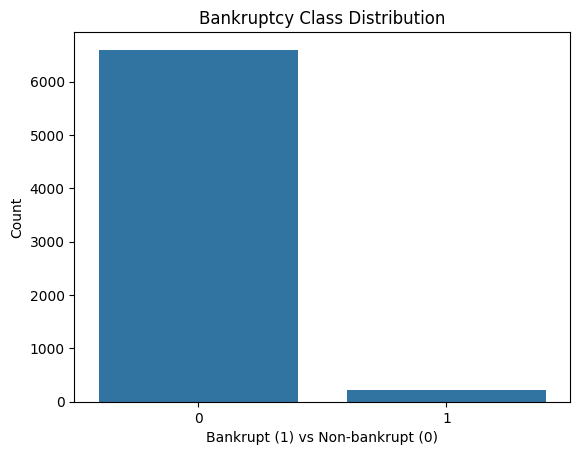

In [ ]:
sns.countplot(x=y)
plt.title("Bankruptcy Class Distribution")
plt.xlabel("Bankrupt (1) vs Non-bankrupt (0)")
plt.ylabel("Count")

## Correlation Heatmap

In [ ]:
# plt.figure(figsize=(15,10))
# sns.heatmap(df_scaled.corr(method="spearman"),cmap="coolwarm",annot=False,center=0)
# plt.title("Correlation matrix")

In [ ]:
# df_scaled.corr(method="spearman")

# Splitting dataset into training and testing set

In [ ]:
x_train,x_test,y_train,y_test=train_test_split(df,y,test_size=0.2)

# SMOTE (Synthetic minority oversampling technique)

In [ ]:
smote=SMOTE(random_state=42)

In [ ]:
x_res,y_res=smote.fit_resample(x_train,y_train)

In [ ]:
y_res.value_counts()

Bankrupt?
0    5275
1    5275
Name: count, dtype: int64

# Saving preprocessed data

In [ ]:
# joblib.dump((x_train,x_test,y_train,y_test),"new_data.pkl")
# joblib.dump((x_res,x_test,y_res,y_test),"smote_data.pkl")

['new_data.pkl']

In [5]:
x_train,x_test,y_train,y_test=joblib.load("/content/drive/MyDrive/new_data.pkl")
x_res,x_test,y_res,y_test=joblib.load("/content/drive/MyDrive/smote_data.pkl")

FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/new_data.pkl'

# Training Models

In [ ]:
def report(model,y_test,y_pred,y_proba):
  if hasattr(model,'n_iter_'):
    print(model.n_iter_)
  print(classification_report(y_test,y_pred))
  print("Confusion Matrix:\n ",confusion_matrix(y_test,y_pred))
  print(f"ROC AUC Score: {roc_auc_score(y_test,y_proba):.2f}")
  print(f"PR AUC score: {average_precision_score(y_test,y_proba):.2f}")
  print(f"Accuracy_score: {accuracy_score(y_test,y_pred):.2f}")

In [ ]:
def threshold_testing(y_proba):
  best_f1=0
  best_thresh=0
  f1_scores=[]
  thresholds=np.arange(0.0,1.01,0.01)
  for tr in thresholds:
    y_pred=(y_proba>=tr).astype(int)
    f1=f1_score(y_test,y_pred)
    f1_scores.append(f1)
    if f1>best_f1:
      best_f1=f1
      best_thresh=tr
  print(f"best_f1: {best_f1:.2f}")
  print(f"best_thresh: {best_thresh:.2f}")


## Logistic Regression

In [ ]:
# (default) penalty- l2, solver-lbfgs, max_iter-100
log_reg=LogisticRegression(max_iter=5000) # solver=lbfgs, penalty=l2
log_reg.fit(x_res,y_res)
y_pred=log_reg.predict(x_test)
y_proba=log_reg.predict_proba(x_test)[:,1]
report(log_reg,y_test,y_pred,y_proba)
threshold_testing(y_proba)

[2900]
              precision    recall  f1-score   support

           0       0.99      0.88      0.94      1324
           1       0.18      0.82      0.29        40

    accuracy                           0.88      1364
   macro avg       0.59      0.85      0.61      1364
weighted avg       0.97      0.88      0.92      1364

Confusion Matrix:
  [[1171  153]
 [   7   33]]
ROC AUC Score: 0.93
PR AUC score: 0.30
Accuracy_score: 0.88
best_f1: 0.42
best_thresh: 0.81


In [ ]:
# solver="liblinear",penalty="l2"
log_reg=LogisticRegression(max_iter=5000,solver="liblinear")
log_reg.fit(x_res,y_res)
y_pred=log_reg.predict(x_test)
y_proba=log_reg.predict_proba(x_test)[:,1]
report(log_reg,y_test,y_pred,y_proba)
threshold_testing(y_proba)

[50]
              precision    recall  f1-score   support

           0       0.99      0.88      0.94      1324
           1       0.17      0.80      0.28        40

    accuracy                           0.88      1364
   macro avg       0.58      0.84      0.61      1364
weighted avg       0.97      0.88      0.92      1364

Confusion Matrix:
  [[1170  154]
 [   8   32]]
ROC AUC Score: 0.93
PR AUC score: 0.30
Accuracy_score: 0.88
best_f1: 0.41
best_thresh: 0.80


In [ ]:
# solver="saga",penalty="l1"
log_reg=LogisticRegression(max_iter=5000,solver="saga",penalty="l1")
log_reg.fit(x_res,y_res)
y_pred=log_reg.predict(x_test)
y_proba=log_reg.predict_proba(x_test)[:,1]
report(log_reg,y_test,y_pred,y_proba)
threshold_testing(y_proba)

[2770]
              precision    recall  f1-score   support

           0       0.99      0.88      0.94      1324
           1       0.17      0.80      0.28        40

    accuracy                           0.88      1364
   macro avg       0.58      0.84      0.61      1364
weighted avg       0.97      0.88      0.92      1364

Confusion Matrix:
  [[1171  153]
 [   8   32]]
ROC AUC Score: 0.93
PR AUC score: 0.30
Accuracy_score: 0.88
best_f1: 0.42
best_thresh: 0.81


In [ ]:
# solver="liblinear",penalty="l1"
log_reg=LogisticRegression(max_iter=5000,solver="liblinear",penalty="l1")
log_reg.fit(x_res,y_res)
y_pred=log_reg.predict(x_test)
y_proba=log_reg.predict_proba(x_test)[:,1]
report(log_reg,y_test,y_pred,y_proba)
threshold_testing(y_proba)

[30]
              precision    recall  f1-score   support

           0       0.99      0.89      0.94      1324
           1       0.18      0.78      0.29        40

    accuracy                           0.89      1364
   macro avg       0.58      0.83      0.61      1364
weighted avg       0.97      0.89      0.92      1364

Confusion Matrix:
  [[1179  145]
 [   9   31]]
ROC AUC Score: 0.93
PR AUC score: 0.31
Accuracy_score: 0.89
best_f1: 0.38
best_thresh: 0.86


## Decision Tree

In [ ]:
dec_clf=DecisionTreeClassifier(max_depth=None)
dec_clf.fit(x_res,y_res)
y_pred=dec_clf.predict(x_test)
y_proba=dec_clf.predict_proba(x_test)[:,1]
report(dec_clf,y_test,y_pred,y_proba)
threshold_testing(y_proba)

              precision    recall  f1-score   support

           0       0.98      0.95      0.97      1324
           1       0.23      0.45      0.31        40

    accuracy                           0.94      1364
   macro avg       0.61      0.70      0.64      1364
weighted avg       0.96      0.94      0.95      1364

Confusion Matrix:
  [[1264   60]
 [  22   18]]
ROC AUC Score: 0.70
PR AUC score: 0.12
Accuracy_score: 0.94
best_f1: 0.31
best_thresh: 0.01


In [ ]:
results=[]
for depth in [3,5,6,7,10]:
  dec_clf=DecisionTreeClassifier(max_depth=depth)
  dec_clf.fit(x_res,y_res)
  y_pred=dec_clf.predict(x_test)
  y_proba=dec_clf.predict_proba(x_test)[:,1]
  threshold_testing(y_proba)

best_f1: 0.35
best_thresh: 0.82
best_f1: 0.36
best_thresh: 0.94
best_f1: 0.38
best_thresh: 0.94
best_f1: 0.36
best_thresh: 0.96
best_f1: 0.34
best_thresh: 0.51


#### We can tune more hyperparameters for decision tree like min_samples_leaf, min_samples_split, max_features, criterion but randomforestclassifier generally performs well than a single decision tree

## RandomForestClassifier

In [ ]:
rnd_clf=RandomForestClassifier(
    n_estimators=150,
    max_depth=8,
)
rnd_clf.fit(x_res,y_res)
y_pred=rnd_clf.predict(x_test)
y_proba=rnd_clf.predict_proba(x_test)[:,1]
report(rnd_clf,y_test,y_pred,y_proba)
threshold_testing(y_proba)

              precision    recall  f1-score   support

           0       0.99      0.93      0.96      1324
           1       0.25      0.75      0.38        40

    accuracy                           0.93      1364
   macro avg       0.62      0.84      0.67      1364
weighted avg       0.97      0.93      0.94      1364

Confusion Matrix:
  [[1235   89]
 [  10   30]]
ROC AUC Score: 0.95
PR AUC score: 0.46
Accuracy_score: 0.93
best_f1: 0.50
best_thresh: 0.82


### GridSearchCV

In [ ]:
params={
    "max_depth":[6,8,10],
    "max_features":["sqrt","log2"],
    "n_estimators":[100,150,200],
    "bootstrap":[True],
}
rnd_clf=RandomForestClassifier()

In [ ]:
grid=GridSearchCV(rnd_clf,params,cv=5,n_jobs=-1,scoring="f1",verbose=2,return_train_score=True)
grid.fit(x_res,y_res)
clf=grid.best_estimator_
print(clf,grid.best_params_,grid.best_score_)
y_pred=clf.predict(x_test)
y_proba=clf.predict_proba(x_test)[:,1]
report(clf,y_test,y_pred,y_proba)
threshold_testing(y_proba)

Fitting 5 folds for each of 18 candidates, totalling 90 fits
RandomForestClassifier(max_depth=10, n_estimators=200) {'bootstrap': True, 'max_depth': 10, 'max_features': 'sqrt', 'n_estimators': 200} 0.9722797806093901
              precision    recall  f1-score   support

           0       0.99      0.95      0.97      1324
           1       0.29      0.72      0.42        40

    accuracy                           0.94      1364
   macro avg       0.64      0.84      0.69      1364
weighted avg       0.97      0.94      0.95      1364

Confusion Matrix:
  [[1254   70]
 [  11   29]]
ROC AUC Score: 0.94
PR AUC score: 0.45
Accuracy_score: 0.94
best_f1: 0.48
best_thresh: 0.81


### Again with wider parameter space

In [ ]:
params={
    "max_depth":[10,12,14],
    "max_features":["sqrt"],
    "n_estimators":[200],
    "bootstrap":[True],
    "min_samples_split":[10,20,40],
    "min_samples_leaf":[5,10,15]
}
rnd_clf=RandomForestClassifier()

In [ ]:
grid=GridSearchCV(rnd_clf,params,cv=5,n_jobs=-1,scoring="f1",verbose=2,return_train_score=True)
grid.fit(x_res,y_res)
clf=grid.best_estimator_
print(grid.best_params_,"best_score: ",grid.best_score_)
y_pred=clf.predict(x_test)
y_proba=clf.predict_proba(x_test)[:,1]
report(clf,y_test,y_pred,y_proba)
threshold_testing(y_proba)

Fitting 5 folds for each of 27 candidates, totalling 135 fits


#### MY MISTAKE- Since SMOTE was applied before cross-validation, we are evaluating on synthetic data which is easier grid.best_score_=0.97 does not represent real world performance

## XGBoostClassifier

#### training on imbalanced dataset(No SMOTE) using scale_pos_weight

In [ ]:
x_boost,x_val,y_boost,y_val=train_test_split(x_train,y_train,test_size=0.15)
y_boost.value_counts()
scale_pos_weight=y_boost.value_counts()[0]/y_boost.value_counts()[1]

In [ ]:
xgb=XGBClassifier(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=5,
    scale_pos_weight=scale_pos_weight,
    eval_metric="aucpr",
    early_stopping_rounds=30
)

#### Unfortunately, XGBoost does not support f1 as a built in eval_metric bcz it is not continous, differentiable function, which makes it hard to optimize during boosting
logloss-default,
auc-good overall measure,
aucpr-better for imbalanced datasets,
error-classification error rate

In [31]:
xgb.fit(
    x_boost,y_boost,
    eval_set=[(x_val,y_val)], #should be a tuple inside a list
    verbose=False
)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=30,
              enable_categorical=False, eval_metric='aucpr', feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.05, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=500,
              n_jobs=None, num_parallel_tree=None, ...)

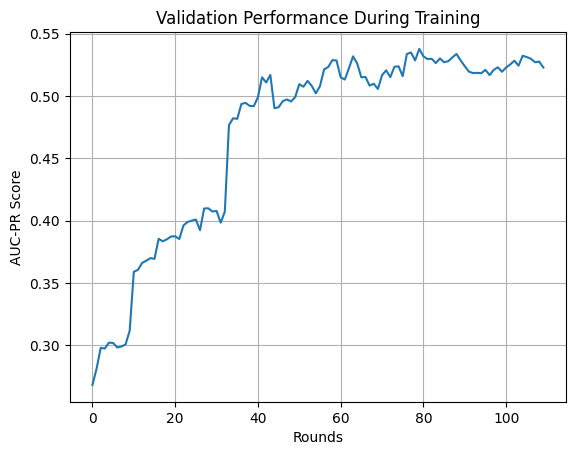

In [36]:
plt.plot(xgb.evals_result()['validation_0']['aucpr'])
plt.xlabel('Rounds')
plt.ylabel('AUC-PR Score')
plt.title('Validation Performance During Training')
plt.grid(True)

In [32]:
xgb.best_iteration,xgb.best_score

(79, 0.5376405715652071)

In [34]:
y_pred=xgb.predict(x_test)
y_proba=xgb.predict_proba(x_test)[:,1]
report(xgb,y_test,y_pred,y_proba)
threshold_testing(y_proba)

              precision    recall  f1-score   support

           0       0.99      0.94      0.97      1324
           1       0.27      0.70      0.39        40

    accuracy                           0.94      1364
   macro avg       0.63      0.82      0.68      1364
weighted avg       0.97      0.94      0.95      1364

Confusion Matrix:
  [[1249   75]
 [  12   28]]
ROC AUC Score: 0.91
PR AUC score: 0.39
Accuracy_score: 0.94
best_f1: 0.45
best_thresh: 0.81


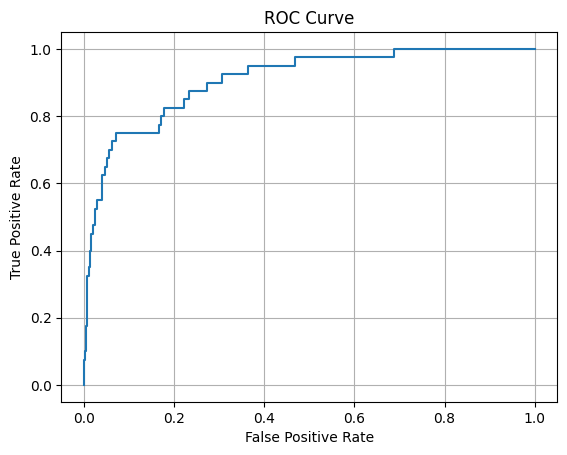

In [37]:
fpr,tpr,_=roc_curve(y_test,y_proba)
plt.plot(fpr,tpr)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.grid(True)

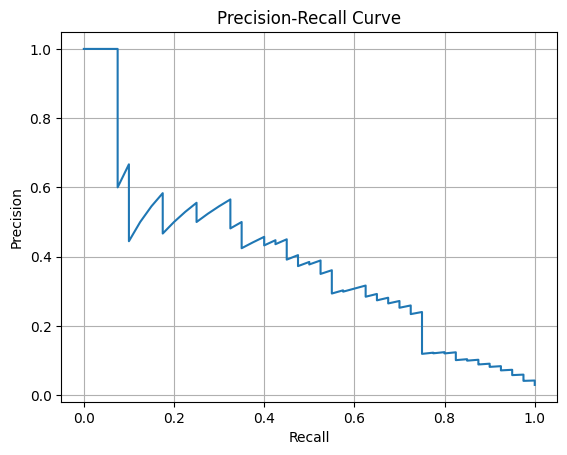

In [38]:
precision,recall,_=precision_recall_curve(y_test,y_proba)
plt.plot(recall,precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.grid(True)

### GridSearchCV

#### We can not use early-stopping with GridSearchCV

In [46]:
params={
    'n_estimators':[300],
    'max_depth':[3,5,7],
    'gamma':[0,0.1,0.3],
    'learning_rate':[0.01,0.05,0.1],
    'subsample':[0.8,1],
    'colsample_bytree':[0.8,1],
    'min_child_weight':[1,5,10]
}
xgb=XGBClassifier(scale_pos_weight=scale_pos_weight,eval_metric="aucpr")

In [47]:
# eval_metric="aucpr" is just for monitoring training progress, not model selection
# scoring="f1" decides which model is best in GridSearchCV
grid=GridSearchCV(
    xgb,params,
    cv=5,
    scoring="f1"
    n_jobs=-1,
    verbose=True
)